# HCLIM Validation

## Loading HCLIM data

Load .tab files and combine all TA (air temperature) data into one pandas dataframe.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyleoclim as pyleo
import os
import xarray as xr

In [3]:
# read all csvs and combine into one dataframe 

files = os.listdir('./datasets/')
data = []
for file in files:
    if ('_Ta' in file) and ('Tair' not in file):
        df = pd.read_csv(f'./datasets/{file}',sep='\t', skiprows=23)
        data.append(df)

df_ta = pd.concat(data)

In [4]:
# identifying all unique station IDs

stations_id = df_ta['ID'].unique()

In [5]:
# create dictionary for all stations with lat/lon, start/end date, and length of timeseries

ta_dict = {}
for id in stations_id:
    station_data = df_ta[df_ta['ID'] == id]
    station_name = station_data['Station'].unique()[0]
    mini = station_data['Date/Time'].min()
    maxi = station_data['Date/Time'].max()
    lat = station_data['Latitude'].unique()[0]
    lon = station_data['Longitude'].unique()[0]
    length = len(station_data['TTT monthly m [°C]'].values)
    ta_dict[id] = {'Station': station_name,
                'Date min': mini,
                'Date max': maxi,
                'Length': length,
                'Latitude': lat,
                'Longitude': lon}




In [6]:
# list 
old_ta = []
for id in stations_id:
    val = int(ta_dict[id]['Date min'][:-3])
    if 1850 >= val:
        old_ta.append(id)


In [7]:
old_ta_dict = {}
for id in old_ta:
    old_ta_dict[id] = ta_dict[id]

In [8]:
sorted_date_dict = dict(sorted(old_ta_dict.items(), 
                         key=lambda x: x[1]['Date min']))

In [9]:
sorted_len_dict = dict(sorted(old_ta_dict.items(), 
                         key=lambda x: x[1]['Length'],
                         reverse = True))

## Loading Paris Dataset (HCLIM)

In [95]:
df_paris = df_ta[df_ta['ID'] == 'EKF400v2t_002']

In [12]:
from datetime import datetime

def date_to_decimal_year(date_str):
    # Parse the date string
    date = datetime.strptime(date_str, '%Y-%m')
    
    # Get the year and month
    year = date.year
    month = date.month
    
    # Convert to decimal year (year + fraction of the year)
    decimal_year = year + (month - 1) / 12
    
    return decimal_year


In [13]:
df_paris['Date/Time'] = df_paris['Date/Time'].apply(date_to_decimal_year)

In [14]:
# loading data as a Pyleoclim series

paris_ps = pyleo.Series(time=df_paris['Date/Time'], value=df_paris['TTT monthly m [°C]'],
                      time_name='Date', time_unit='year', verbose=False,
                      value_name='Temperature', value_unit='C')

In [96]:
df_paris['Date/Time']

324656    1658-01
324657    1658-02
324658    1658-03
324659    1658-04
324660    1658-05
           ...   
328983    2018-08
328984    2018-09
328985    2018-10
328986    2018-11
328987    2018-12
Name: Date/Time, Length: 4332, dtype: object

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year]', ylabel='Temperature [C]'>)

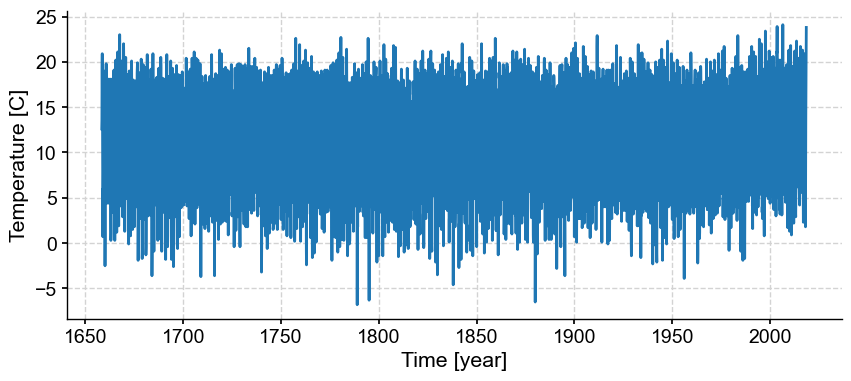

In [93]:
paris_ps.plot()

In [33]:
centered_paris = paris_ps.center([1951,1980])

### Adjusting anomalies to remove seasonal cycles, and annualize

In [ ]:

years = np.floor(df_paris['Date/Time'])

paris_annual = df_paris.groupby(years)['TTT monthly m [°C]'].mean()

ref_period_mean = paris_annual[
    (paris_annual.index >= 1951) & 
    (paris_annual.index <= 1980)
].mean()

# Calculate anomalies
paris_annual_anomalies = paris_annual - ref_period_mean

In [ ]:
timey = paris_annual_anomalies.index.values  
valuey = paris_annual_anomalies.values

paris_annual_ps = pyleo.Series(
    time=timey,
    value=valuey,
    time_name='Year',
    time_unit= 'year',
    value_name='Temperature anomaly',
    value_unit='°C'
)

Time axis values sorted in ascending order


### Visualizing 

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year]', ylabel='Temperature anomaly [°C]'>)

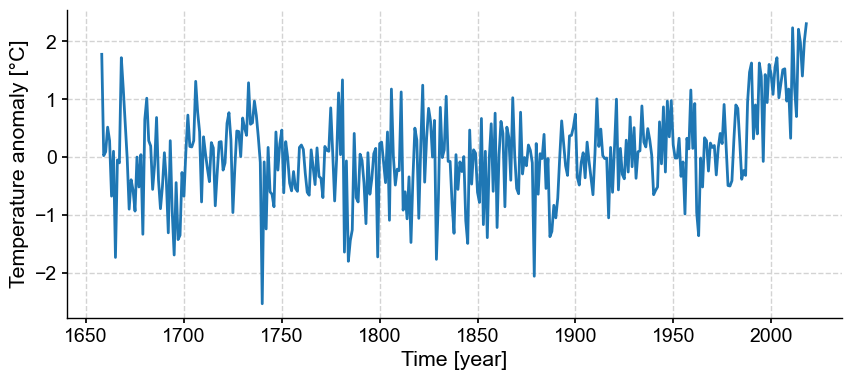

In [66]:
paris_annual_ps.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year]', ylabel='Temperature [C]'>)

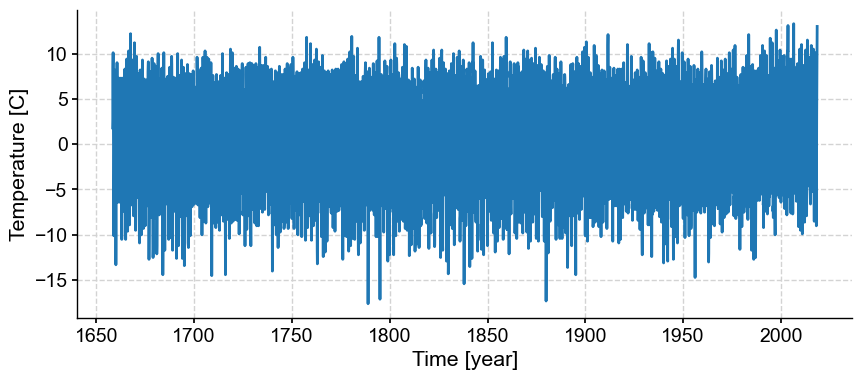

In [34]:
centered_paris.plot()

In [ ]:
paris_slice = centered_paris.sel(time=slice(1650, 1850)) #using pyleoclim center (monthly resolution)
paris_annual_slice = paris_annual_ps.sel(time=slice(1650, 1850)) # not pyloclim (annual mean)

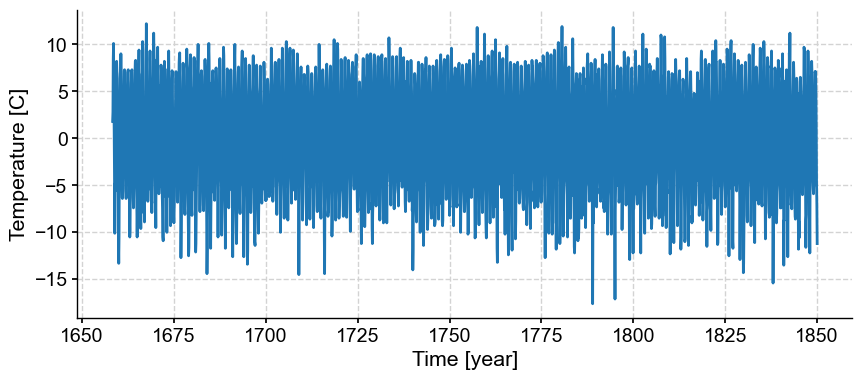

In [36]:
fig, ax = paris_slice.plot(label='Original')

## Loading New Haven, CT (HCLIM)

In [83]:
df_nh = df_ta[df_ta['ID'] == 'BE-68050'] 

In [84]:
df_nh['Date/Time'] = df_nh['Date/Time'].apply(date_to_decimal_year)

In [85]:
nh_ps = pyleo.Series(time=df_nh['Date/Time'], value=df_nh['TTT monthly m [°C]'],
                      time_name='Date', time_unit='year', verbose=False,
                      value_name='Temperature', value_unit='C')

In [86]:
nh_slice = nh_ps.sel(time=slice(1750, 1850))

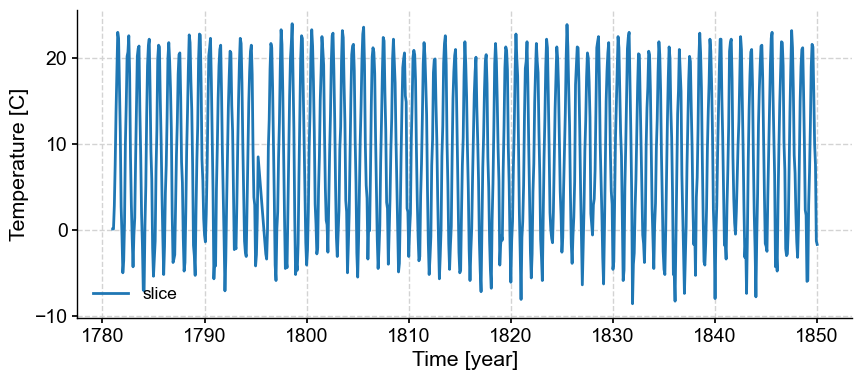

In [ ]:
fig, ax = nh_slice.plot(label='nh ')
ax.legend()

## Loading LMRv2.1 

In [97]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})
lmr_ds_gridded

<xarray.Dataset>
Dimensions:        (time: 2001, MCrun: 20, lat: 91, lon: 180)
Coordinates:
  * lat            (lat) float32 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon            (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time           (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: MCrun
Data variables: (12/14)
    air_mean       (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    air_spread     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    hgt500_mean    (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    hgt500_spread  (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    pdsi_mean      (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    pdsi_spread    (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    ...             ...
    prate_mean     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prate_spread   (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prmsl_mean     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prmsl_spread   (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    sst_mean       (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    sst_spread     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
Attributes:
    comment:      File contains ensemble spread values for each Monte-Carlo r...
    description:  Last Millennium Reanalysis climate field reconstruction for...
    experiment:   productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_z500

### Loading Paris gridpoint (LMR)

In [27]:
grid_point_paris = lmr_ds_gridded.air_mean.isel(lat=49, lon=2)

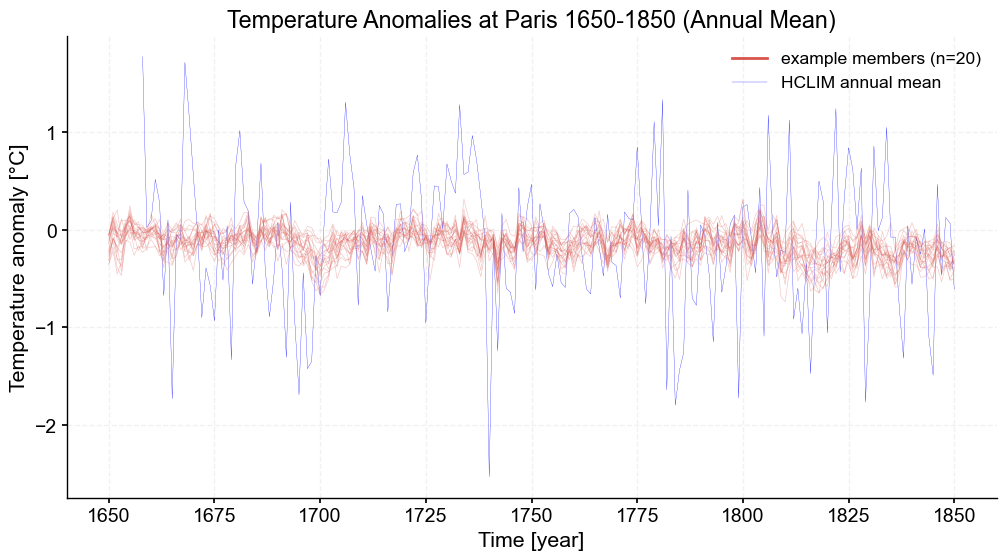

In [74]:
time_values_numeric = np.array([t.year for t in grid_point_paris.time.values])
mask = (time_values_numeric >= 1650) & (time_values_numeric <= 1850)

traces = []
for i in range(grid_point_paris.shape[1]):
    values = grid_point_paris[mask, i].values
    
    series = pyleo.Series(
        time=time_values_numeric[mask],  # Only use times within our period
        value=values,
        time_name='Year',
        time_unit='CE',
        value_name='Air Temperature',
        value_unit='°C',
        label=f'Ensemble Member {i+1}',
        verbose=False
    )
    traces.append(series)

# Create an EnsembleSeries object
ensemble = pyleo.EnsembleSeries(traces)

# Create visualization
fig, ax = ensemble.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6)
)

paris_annual_slice.plot(ax=ax, linewidth=0.2, color='blue', label='HCLIM annual mean')

ax.set_title('Temperature Anomalies at Paris 1650-1850 (Annual Mean)')
ax.grid(True, alpha=0.3)
ax.legend()

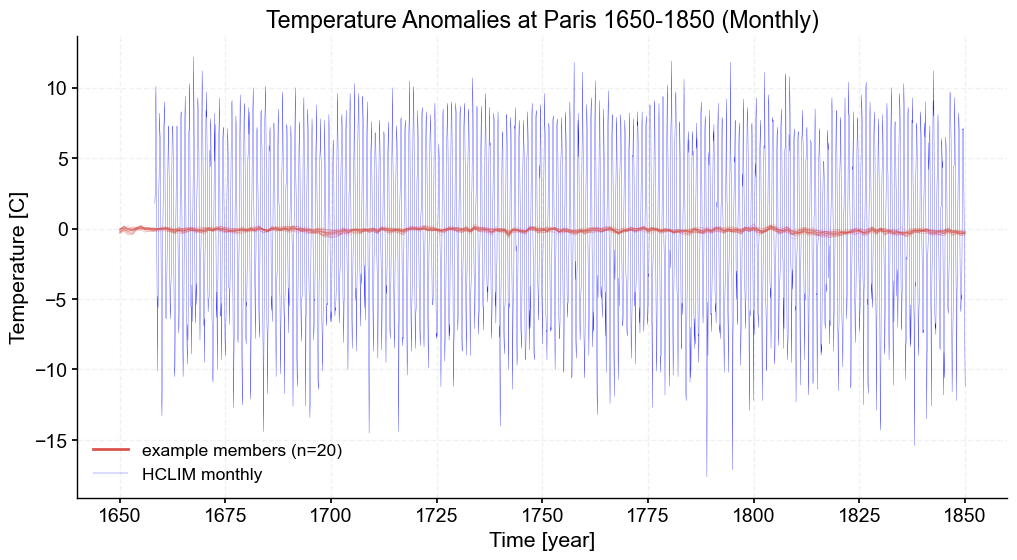

In [76]:
fig, ax = ensemble.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6)
)

paris_slice.plot(ax=ax, linewidth=0.2, color='blue', label='HCLIM monthly')

ax.set_title('Temperature Anomalies at Paris 1650-1850 (Monthly)')
ax.grid(True, alpha=0.3)
ax.legend()

### Loading New Haven Gridpoint (LMR)

In [89]:
grid_point_nh = lmr_ds_gridded.air_mean.isel(lat=41, lon=-73)

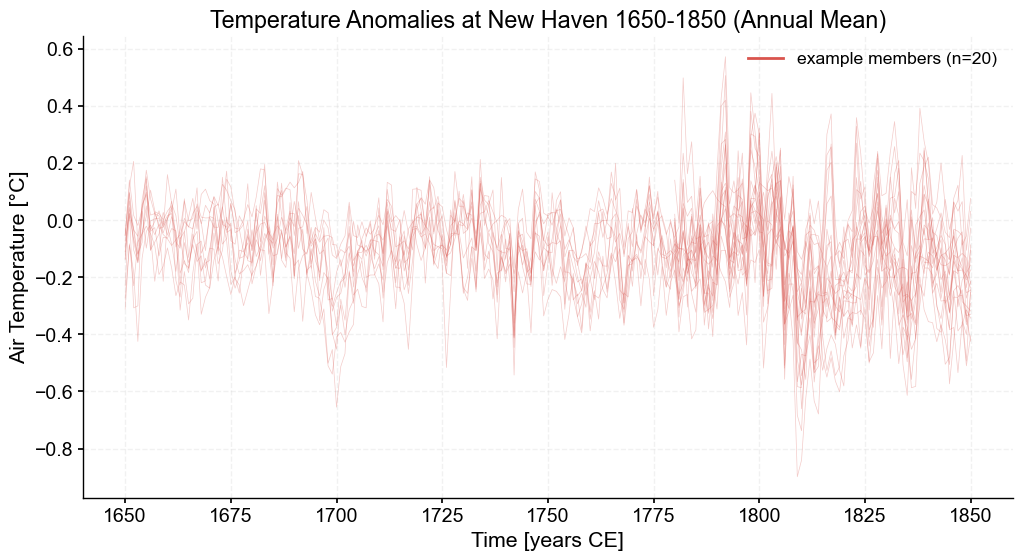

In [91]:
time_values_numeric = np.array([t.year for t in grid_point_nh.time.values])
mask = (time_values_numeric >= 1780) & (time_values_numeric <= 1850)

for i in range(grid_point_nh.shape[1]):
    values = grid_point_nh[mask, i].values
    
    series = pyleo.Series(
        time=time_values_numeric[mask],  # Only use times within our period
        value=values,
        time_name='Year',
        time_unit='CE',
        value_name='Air Temperature',
        value_unit='°C',
        label=f'Ensemble Member {i+1}',
        verbose=False
    )
    traces.append(series)

# Create an EnsembleSeries object
ensemble_nh = pyleo.EnsembleSeries(traces)

# Create visualization
fig, ax = ensemble_nh.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6)
)

#paris_annual_slice.plot(ax=ax, linewidth=0.2, color='blue', label='HCLIM annual mean')

ax.set_title('Temperature Anomalies at New Haven 1650-1850 (Annual Mean)')
ax.grid(True, alpha=0.3)
ax.legend()